# Applying NLP for topic modelling and sentiment analysis on customer reviews for a large gym chain

Applying NLP for topic modelling is crucial for data analysis in business because it enables companies to identify and understand key themes and patterns within large volumes of text data. This efficiency allows businesses to extract essential insights and trends without manually sifting through extensive documents. Automated topic modelling helps businesses make informed decisions faster, which helps to improve productivity and gain a competitive edge. Additionally, it supports better information management by uncovering underlying topics in reports, emails, customer feedback, and market research, which enhances overall business intelligence and strategic planning.

## Business context

The PureGym Group, founded in 2008, has approximately 2 million members and 600 gyms across the world (particularly in the UK, Denmark, and Switzerland). As one of the world’s largest value fitness operators, PureGym appeals to a broad range of customers by offering high-quality, low-cost, and flexible fitness facilities.

This focus on the customer is centred on wanting to understand what motivates members to join and what factors influence their behaviours once they have joined. Internet reviews provide a large data set of natural language containing positive, negative and neutral customer experiences that would require an enormous amount of time to analyse manually. Using machine learning to derive insights and trends from the data can generate actionable intelligence much more time effectively, which can be used to improve the customer experience while retaining the value-for-money proposition.

## Conducting initial data investigation

The data for this case study comes from customer reviews posted on Google Reviews and Trustpilot. They contain a large number of reviews as natural language that will be analysed for common topics & sentiments, and be used to generate business recommendations to improve the customer experience.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer
import string

from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
from bertopic import BERTopic
import torch

In [ ]:
import warnings

warnings.filterwarnings(action="ignore", message=r"datetime.datetime.utcnow")

In [ ]:
# Load the data into dataframes
google_df = pd.read_excel("/content/CAM DS 301 Week 4&5 Topic project data sets/Google_12_months.xlsx")
trustpilot_df = pd.read_excel("/content/CAM DS 301 Week 4&5 Topic project data sets/Trustpilot_12_months.xlsx")

### EDA / Data Processing - Google

The Google reviews dataset contains a Dataframe with 7 features:

*   `Customer Name` - The name of the customer who left the review (anonymised)
*   `SurveyID for external use (e.g. tech support)` - The reference number for the survey
*   `Club's Name` - The location of the gym referenced in the review
*   `Social Media Source` - The source of the review (Google reviews)
*   `Creation Date` - The date that the review was left
*   `Comment` - The text review that was left by the customer
*   `Overall Score` - The score of the relevant gym out of 5

The data will be pre-processed to select the relevant features for analysis, handle any missing information and align the feature names with the other data set for clarity and simplicity.

In [ ]:
# Display the shape and first few rows of the google data set.
print(google_df.shape)
google_df.head()

(23250, 7)


,Customer Name,SurveyID for external use (e.g. tech support),Club's Name,Social Media Source,Creation Date,Comment,Overall Score
0,**,ekkt2vyxtkwrrrfyzc5hz6rk,Leeds City Centre North,Google Reviews,2024-05-09 23:49:18,NaN,4
1,**,e9b62vyxtkwrrrfyzc5hz6rk,Cambridge Leisure Park,Google Reviews,2024-05-09 22:48:39,Too many students from two local colleges go h...,1
2,**,e2dkxvyxtkwrrrfyzc5hz6rk,London Holborn,Google Reviews,2024-05-09 22:08:14,"Best range of equipment, cheaper than regular ...",5
3,**,e3tfxvyxtkwrrrfyzc5hz6rk,Cheshunt Brookfield Shopping Park,Google Reviews,2024-05-09 21:58:07,"Good gym when it’s not busy, tend to get too b...",4
4,**,edkrxvyxtkwrrrfyzc5hz6rk,Bristol Union Gate,Google Reviews,2024-05-09 21:48:00,"(current member)\n\nGym is quite dirty, more o...",1


In [ ]:
# Drop the unnecessary columns
cols_to_drop = ['Customer Name','SurveyID for external use (e.g. tech support)']
google_df = google_df.drop(cols_to_drop, axis=1)

In [ ]:
# Rename columns
google_df.rename(columns={"Club's Name": "Gym_Location",
                          "Social Media Source": "Review_Source",
                          "Creation Date": "Review_Date",
                          "Overall Score": "Score",
                          }, inplace=True)

In [ ]:
# Check for missing or null values
google_df.isnull().sum()

,0
Gym_Location,0
Review_Source,0
Review_Date,0
Comment,9352
Score,0


As the purpose of this task is to analyse the text comments that are left as reviews, any rows with missing data in this feature will be dropped.

In [ ]:
# Drop rows where the Comment column is missing
google_df.dropna(subset=['Comment'], inplace=True)

In [ ]:
# Check unique values
google_df.nunique()

,0
Gym_Location,512
Review_Source,1
Review_Date,10423
Comment,13506
Score,5


In [ ]:
# Ensure creation date is in datetime format
google_df['Review_Date'] = pd.to_datetime(google_df['Review_Date'])

In [ ]:
# Check column data types
google_df.dtypes

,0
Gym_Location,object
Review_Source,object
Review_Date,datetime64[ns]
Comment,object
Score,int64


As a first step in analysing the data it will be good to understand at a high level the customer sentiment in the reviews. Before getting in to Natural Language Processing, we can estimate this by plotting the distribution of the customer score out of 5 associated with each review.

In [ ]:
def plot_score_distribution(df):
    """
    Plots the number of reviews received for each score
    """
    plt.figure(figsize=(7,7))
    sns.set_style("whitegrid")
    ax = sns.countplot(x="Score", data=df)
    plt.show()

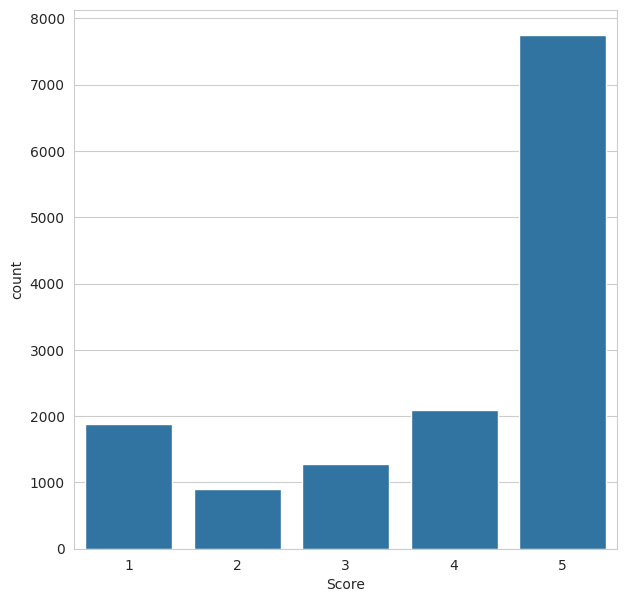

In [ ]:
plot_score_distribution(google_df)

The plot shows that the most common score given when reviewing is 5/5, which indicates that in general customers are happy with their experience

It will also be useful to see how the number of reviews have changed over time which could be indicative of any improvement / worsening of the customer experience.

In [ ]:
def plot_reviews_over_time(df):
    """
    Plots the number of reviews received over time for each score
    """
    # Count frequency of reviews per date per score
    review_counts = df.groupby(["Review_Date", "Score"]).size().unstack(fill_value=0)

    # Resample the data to weekly or monthly frequency
    # review_counts = review_counts.resample("W").sum()   # weekly
    review_counts = review_counts.resample("M").sum()   # monthly

    # Plot
    plt.figure(figsize=(10,6))
    for score in sorted(review_counts.columns):
        plt.plot(review_counts.index, review_counts[score], marker="o", label=f"Score {score}")

    plt.title("Frequency of Reviews Over Time by Score")
    plt.xlabel("Date")
    plt.ylabel("Number of Reviews")
    plt.legend(title="Review Score")
    plt.grid(True)
    plt.show()

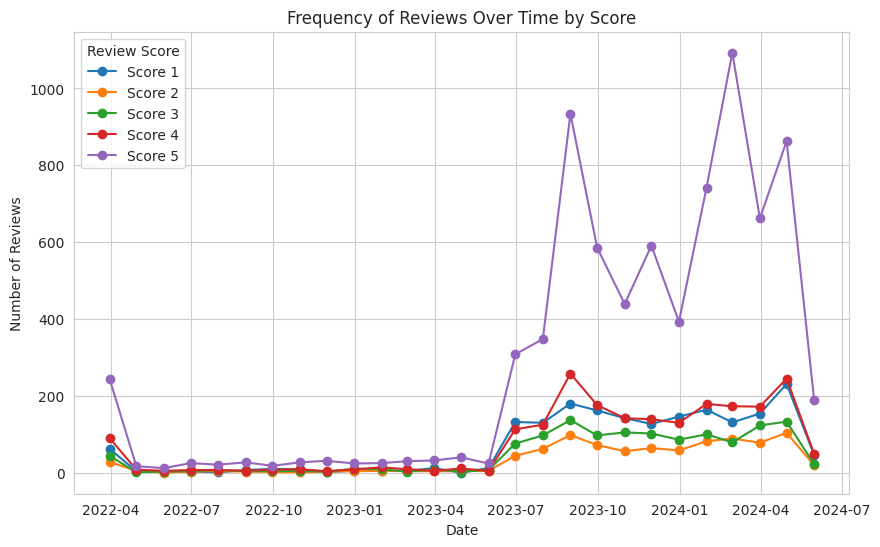

In [ ]:
plot_reviews_over_time(google_df)

The number of Google reviews appears to dramatically increase after mid-2023. It will be useful to understand what the reason for this is and whether it could be indicative of any missing data for the early part of the reviews.

It will also be good to understand how the proportion of reviews has changed for each score to give a clearer picture of how the customer sentiment may be changing over time.

In [ ]:
def plot_percentage_reviews_score(df):
    """
    Plots the percentage of reviews received for each score over time
    """
    review_counts = df.groupby(["Review_Date", "Score"]).size().unstack(fill_value=0)
    review_counts = review_counts.resample("M").sum()   # monthly
    review_counts = review_counts.cumsum(axis=0)
    review_counts = review_counts.div(review_counts.sum(axis=1), axis=0)
    review_counts = review_counts.mul(100)

    plt.figure(figsize=(10,6))
    for score in sorted(review_counts.columns):
        plt.plot(review_counts.index, review_counts[score], marker="o", label=f"Score {score}")

    plt.title("Percentage of Reviews Received Over Time by Score")
    plt.xlabel("Date")
    plt.ylabel("Percentage of Reviews")
    plt.legend(title="Review Score")
    plt.grid(True)
    plt.show()

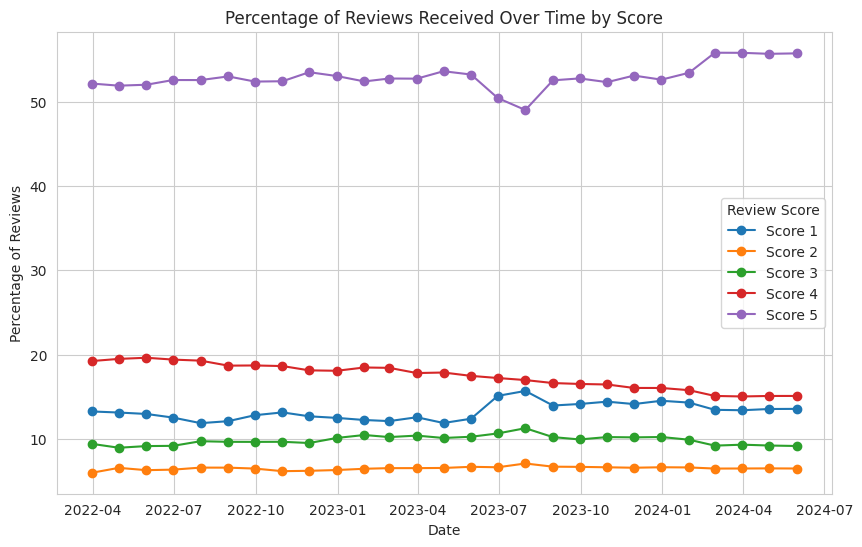

In [ ]:
plot_percentage_reviews_score(google_df)

The Google reviews show that over 50% of reviews are giving the gym a 5/5 score, which suggests that the customers are mostly extremely happy with their experience. The proportions stay in the same order across the entire time frame, but there are some minor fluctuations in proportions, with those scoring 4/5 decreasing over time.

### EDA - Trustpilot

The Trustpilot reviews dataset contains a Dataframe with 15 features:

*   `Review ID` - The unique identifier for the review
*   `Review Created (UTC)` - The date that the review was left
*   `Review Consumer User ID` - The unique identifier for the customer
*   `Review Title` - The title of the review
*   `Review Content` - The text comment of the review
*   `Review Stars` - The score of the relevant gym out of 5
*   `Source of Review` - Where the review was taken from
*   `Review Language` - The language that the review text is written in
*   `Domain URL` - The website of the business
*   `Webshop Name` - The entity name of the business
*   `Business Unit ID` - The unique identifier for the business
*   `Tags` - Extra identifying tags
*   `Company Reply Date (UTC)` - The date that the company replied to the review
*   `Location Name` - The location of the gym being reviewed
*   `Location ID` The unique identifier for the location of the gym

The data will be pre-processed to select the relevant features for analysis, handle any missing information and align the feature names with the other data set for clarity and simplicity.

In [ ]:
# Display the shape and first few rows of the trustpilot data set.
print(trustpilot_df.shape)
trustpilot_df.head()

(16673, 15)


,Review ID,Review Created (UTC),Review Consumer User ID,Review Title,Review Content,Review Stars,Source Of Review,Review Language,Domain URL,Webshop Name,Business Unit ID,Tags,Company Reply Date (UTC),Location Name,Location ID
0,663d40378de0a14c26c2f63c,2024-05-09 23:29:00,663d4036d5fa24c223106005,A very good environment,A very good environment,5,AFSv2,en,http://www.puregym.com,PureGym UK,508df4ea00006400051dd7b1,NaN,2024-05-10 08:12:00,Solihull Sears Retail Park,7b03ccad-4a9d-4a33-9377-ea5bba442dfc
1,663d3c101ccfcc36fb28eb8c,2024-05-09 23:11:00,5f5e3434d53200fa6ac57238,I love to be part of this gym,I love to be part of this gym. Superb value fo...,5,AFSv2,en,http://www.puregym.com,PureGym UK,508df4ea00006400051dd7b1,NaN,2024-05-10 08:13:00,Aylesbury,612d3f7e-18f9-492b-a36f-4a7b86fa5647
2,663d375859621080d08e6198,2024-05-09 22:51:00,57171ba90000ff000a18f905,Extremely busy,"Extremely busy, no fresh air.",1,AFSv2,en,http://www.puregym.com,PureGym UK,508df4ea00006400051dd7b1,NaN,NaT,Sutton Times Square,0b78c808-f671-482b-8687-83468b7b5bc1
3,663d4fa1f25670a3339ccf6d,2024-05-09 22:35:00,663d4fa0d5fa24251d1068e7,Great vibes,"Great vibes, fantastic gym",5,AFSv2,en,http://www.puregym.com,PureGym UK,508df4ea00006400051dd7b1,NaN,NaT,London Finchley,bc3a9a8c-defe-47b3-8ee6-f73a03b7447e
4,663d3251d8367b7b3c4ace64,2024-05-09 22:30:00,60c20598384d84001a4250de,Everything it needs to be,"Clean, well managed, classes are good.",5,AFSv2,en,http://www.puregym.com,PureGym UK,508df4ea00006400051dd7b1,NaN,2024-05-10 08:14:00,Crayford,9ce470b7-57df-4533-af2f-c539422fed14


In [ ]:
# Drop unneccesary columns
cols_to_drop = ['Review ID', 'Review Consumer User ID', 'Review Title', 'Source Of Review', 'Domain URL', 'Webshop Name', 'Business Unit ID', 'Tags', 'Company Reply Date (UTC)', 'Location ID']
trustpilot_df = trustpilot_df.drop(cols_to_drop, axis=1)

In [ ]:
# Rename columns
trustpilot_df.rename(columns={"Location Name": "Gym_Location",
                             "Review Content": "Comment",
                             "Review Created (UTC)": "Review_Date",
                             "Review Stars": "Score",
                             }, inplace=True)

In [ ]:
# Add a column for the source of the review
trustpilot_df['Review_Source'] = 'Trustpilot'

In [ ]:
# Check for missing or null values
trustpilot_df.isnull().sum()

,0
Review_Date,0
Comment,0
Score,0
Review Language,0
Gym_Location,5350
Review_Source,0


The Trustpilot data set only shows missing values in the `Gym_Location` feature. As there are a lot of missing rows we will not drop these as they still contain useful information in the `Comment` feature that we can still analyse.

In [ ]:
# Determine number of unique values
trustpilot_df.nunique()

,0
Review_Date,15332
Comment,16366
Score,5
Review Language,20
Gym_Location,376
Review_Source,1


The Truspilot data set also includes some information on the language that the review is written in. For simplicity it would be easier to analyse Natural Language in a single language, but the foreign text could be translated if it made up a significant amount.

In [ ]:
# Examine review language distribution
trustpilot_df['Review Language'].value_counts()

,count
Review Language,
en,16581
da,34
pl,9
pt,9
es,9
it,6
ro,6
fr,4
de,4


In [ ]:
# Show the reviews not in english
trustpilot_df[trustpilot_df['Review Language'] != 'en']

,Review_Date,Comment,Score,Review Language,Gym_Location,Review_Source
218,2024-05-05 19:57:00,Amo questa palestra perché : l’aria per le don...,5,it,Rochdale,Trustpilot
637,2024-04-29 19:59:00,hassel free,5,da,NaN,Trustpilot
900,2024-04-26 11:16:00,Super polecam Ja K.M,5,pl,Edinburgh Fort Kinnaird,Trustpilot
1204,2024-04-20 23:37:00,No wifi internet,3,bg,NaN,Trustpilot
1335,2024-04-18 10:04:00,Very good 👍 and klineng,5,ar,NaN,Trustpilot
...,...,...,...,...,...,...
16287,2023-05-24 08:00:00,Bueno en mi caso el staff del gym es excelente...,5,es,NaN,Trustpilot
16296,2023-05-23 22:32:00,Bikeholdene tirsdag eftermiddag i Fredericia e...,5,da,NaN,Trustpilot
16300,2023-05-23 21:19:00,glad for jer søde sager har,5,da,Aberdeen Kittybrewster,Trustpilot
16349,2023-05-22 12:46:00,Um lugar que me sinto muito à vontade bora aca...,5,pt,NaN,Trustpilot


As the reviews not written in English do not make up a significant proportion of the data, we can drop these rows for ease.

In [ ]:
# Drop the reviews not in english
trustpilot_df = trustpilot_df[trustpilot_df['Review Language'] == 'en']

# Drop the Reviw Language column
trustpilot_df = trustpilot_df.drop(['Review Language'], axis=1)

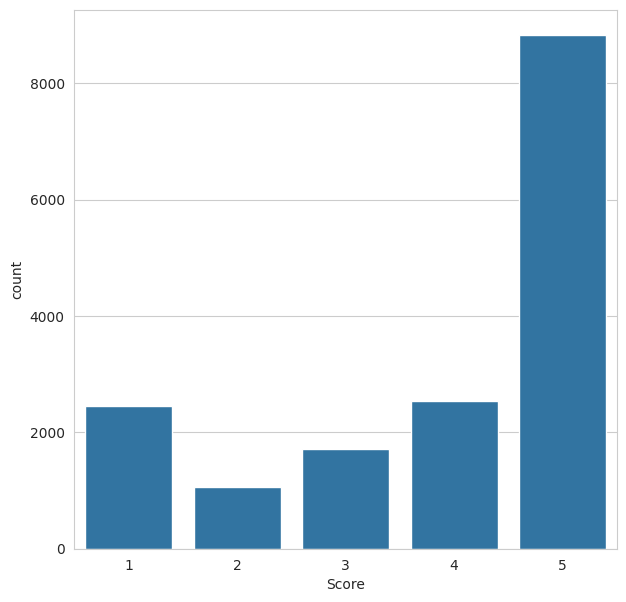

In [ ]:
plot_score_distribution(trustpilot_df)

Again the score plots show that the most common score given to the gyms by the customers is 5/5.

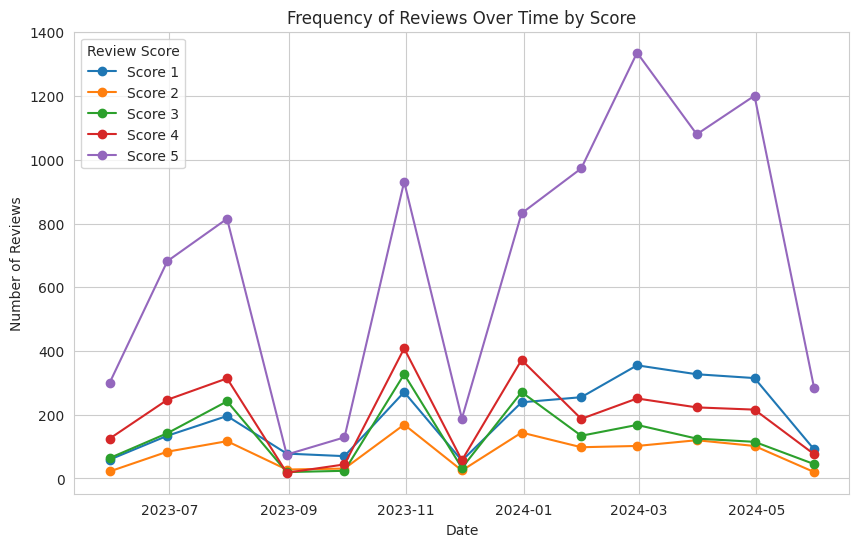

In [ ]:
plot_reviews_over_time(trustpilot_df)

The number of reviews show quite a lot of fluctiation, which could be indicative of the times when the gyms are most busy (e.g. January) and when they are most quiet (e.g. December).

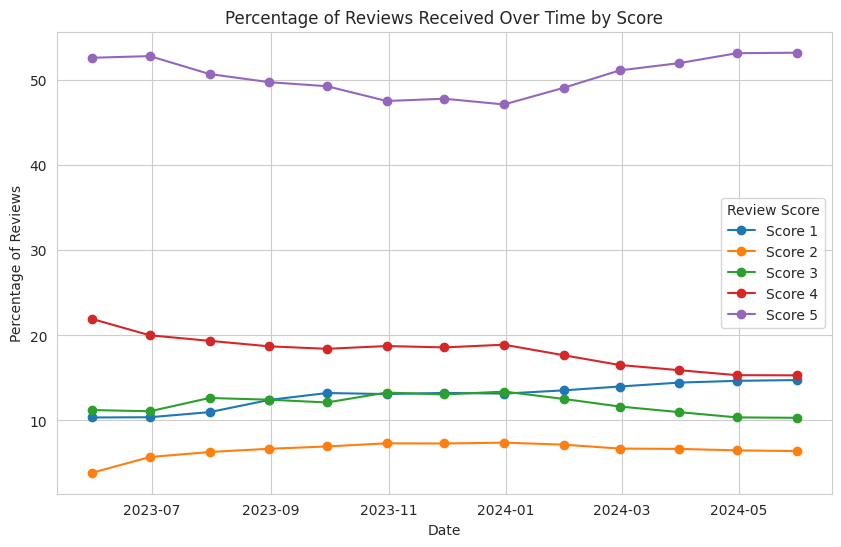

In [ ]:
plot_percentage_reviews_score(trustpilot_df)

Again, 5/5 reviews generally make up over 50% of the reviews that are left. The Trustpilot reviews also show 4/5 reviews decreasing over time and 1/5 reviews increasing. This could be indicative of a worsening customer experience.

### Combined Data Set

As both of the data sets appear to have similar trends in the sentiment of the reviews, and we have aligned the column names in previous steps, so we can now combine the Dataframes to analyse all of the data together.

In [ ]:
print(google_df.shape)
google_df.head()

(13898, 5)


,Gym_Location,Review_Source,Review_Date,Comment,Score
1,Cambridge Leisure Park,Google Reviews,2024-05-09 22:48:39,Too many students from two local colleges go h...,1
2,London Holborn,Google Reviews,2024-05-09 22:08:14,"Best range of equipment, cheaper than regular ...",5
3,Cheshunt Brookfield Shopping Park,Google Reviews,2024-05-09 21:58:07,"Good gym when it’s not busy, tend to get too b...",4
4,Bristol Union Gate,Google Reviews,2024-05-09 21:48:00,"(current member)\n\nGym is quite dirty, more o...",1
5,"209 - Slagelse, Jernbanegade",Google Reviews,2024-05-09 21:36:17,Kom og betalte for en prøvetime i centret. Fik...,1


In [ ]:
print(trustpilot_df.shape)
trustpilot_df.head()

(16581, 5)


,Review_Date,Comment,Score,Gym_Location,Review_Source
0,2024-05-09 23:29:00,A very good environment,5,Solihull Sears Retail Park,Trustpilot
1,2024-05-09 23:11:00,I love to be part of this gym. Superb value fo...,5,Aylesbury,Trustpilot
2,2024-05-09 22:51:00,"Extremely busy, no fresh air.",1,Sutton Times Square,Trustpilot
3,2024-05-09 22:35:00,"Great vibes, fantastic gym",5,London Finchley,Trustpilot
4,2024-05-09 22:30:00,"Clean, well managed, classes are good.",5,Crayford,Trustpilot


In [ ]:
# Combine the dataframes
combined_df = pd.concat([google_df, trustpilot_df], ignore_index=True)

print(combined_df.shape)
combined_df.head()

(30479, 5)


,Gym_Location,Review_Source,Review_Date,Comment,Score
0,Cambridge Leisure Park,Google Reviews,2024-05-09 22:48:39,Too many students from two local colleges go h...,1
1,London Holborn,Google Reviews,2024-05-09 22:08:14,"Best range of equipment, cheaper than regular ...",5
2,Cheshunt Brookfield Shopping Park,Google Reviews,2024-05-09 21:58:07,"Good gym when it’s not busy, tend to get too b...",4
3,Bristol Union Gate,Google Reviews,2024-05-09 21:48:00,"(current member)\n\nGym is quite dirty, more o...",1
4,"209 - Slagelse, Jernbanegade",Google Reviews,2024-05-09 21:36:17,Kom og betalte for en prøvetime i centret. Fik...,1


In [ ]:
combined_df.tail()

,Gym_Location,Review_Source,Review_Date,Comment,Score
30474,Rushden,Trustpilot,2023-05-16 23:30:00,I enjoy the classes and the weights etc are ea...,4
30475,Yate,Trustpilot,2023-05-16 23:18:00,"Happy and helpful staff, feel very comfortable...",5
30476,NaN,Trustpilot,2023-05-16 23:16:00,Showers never maintain the same temp. Not clea...,4
30477,NaN,Trustpilot,2023-05-16 23:15:00,Getting back to gym after be off for 3 months ...,5
30478,Birmingham Maypole,Trustpilot,2023-05-16 23:05:00,I feel that that this gym is a great place to ...,5


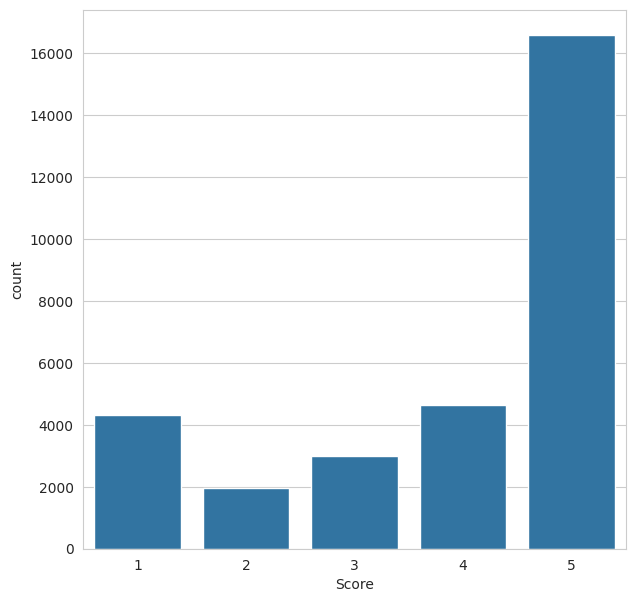

In [ ]:
plot_score_distribution(combined_df)

As the two data sets had similar score profiles, the combined data set shows the same picture as before with most customers scoring the gym 5/5.

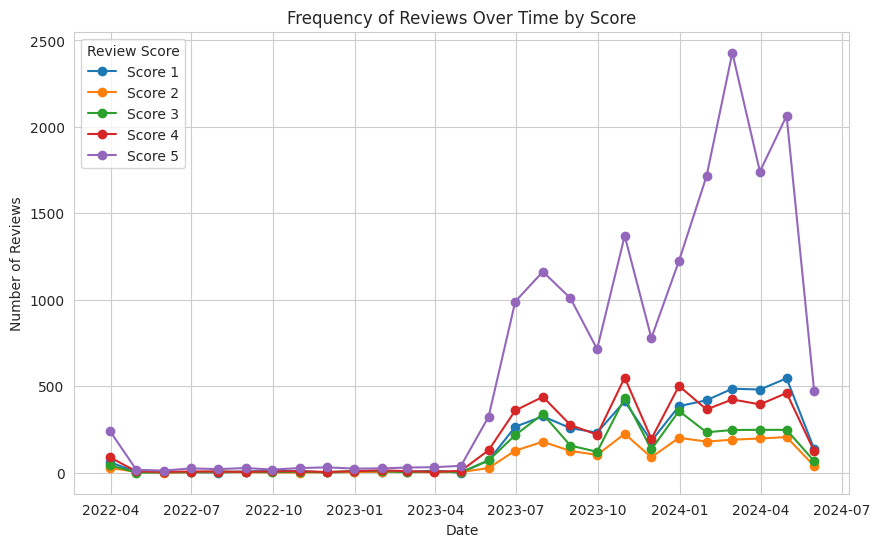

In [ ]:
plot_reviews_over_time(combined_df)

The reviews over time show a similar pattern to the Google data set as there are no early reviews in the Trustpilot set.

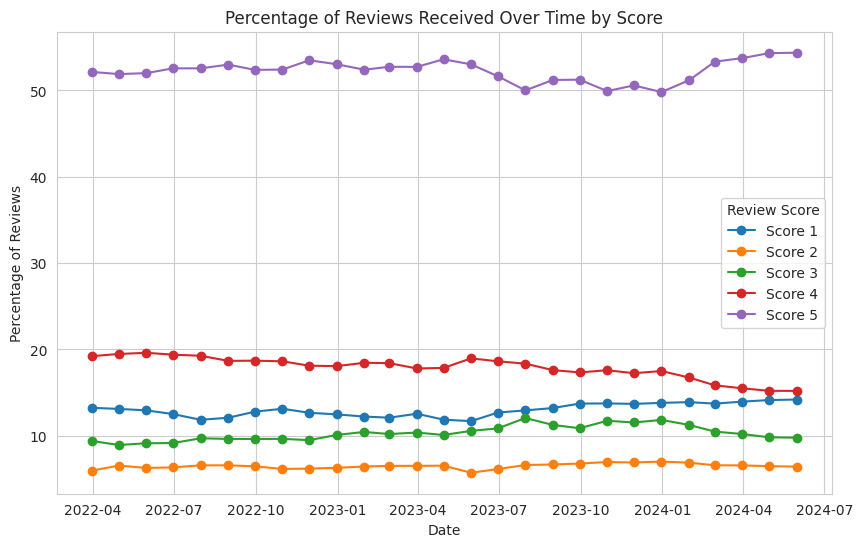

In [ ]:
plot_percentage_reviews_score(combined_df)

The combined data set again shows that 5 star reviews generally make up more than 50% of the total reviews. 4 star reviews are trending downwards over time and 1 star reviews are trending upwards.

## Initial Natural Language Processing (NLP)

For the initial Natural Language Processing (NLP) we will perform some rudimentary tasks that display common words that are used in the reviews. These words can give us an initial insight into the sentiment behind the reviews and perhaps the topics that the reviews frequently mention. We will do this by plotting a bar chart and word cloud of frequent words.

Prior to plotting the data, we will remove stop words which are words that are frequently used but typically convey no meaning on their own (you, me, the, is, etc.) We will also add some specific words that we expect to see in the reviews that also convey no meaning on their own (gym, puregym etc.)

In [ ]:
# Download relevant files for preprocessing
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

In [ ]:
def word_cloud_display(df):
    """
    Performs pre-processing of the data – change to lower case, remove stopwords using NLTK, and remove numbers.
    Then plots a histogram/bar plot showing the top 10 words from each data set and word cloud
    """
    top_number_of_results = 100
    all_reviews = df["Comment"].str.lower().str.cat(sep=' ')
    all_text = re.sub('[^A-Za-z]+', ' ', all_reviews)

    # Define stop words
    stop_words = set(stopwords.words('english'))
    additional_words = ['pure', 'gym', 'puregym', 'workout']
    stop_words.update(additional_words)

    word_tokens = word_tokenize(all_text)
    filtered_all_reviews = [w for w in word_tokens if not w in stop_words]
    filtered_all_reviews = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_all_reviews.append(w)

    all_reviews_no_short_words = [word for word in filtered_all_reviews if len(word) > 2]
    all_reviews_no_numbers = [word for word in all_reviews_no_short_words if not word.isnumeric()]
    word_distribution = nltk.FreqDist(all_reviews_no_numbers)
    reviews_word_frequency_distribution_df = pd.DataFrame(word_distribution.most_common(top_number_of_results),
                    columns=['Word', 'Frequency'])

    plt.figure(figsize=(10,10))
    sns.set_style("whitegrid")
    ax = sns.barplot(x="Word",y="Frequency", data=reviews_word_frequency_distribution_df.head(10))

    plt.figure(figsize = (10,10))
    wc = WordCloud(background_color = 'black', max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(all_reviews_no_numbers))
    plt.imshow(wc)
    plt.axis('off')

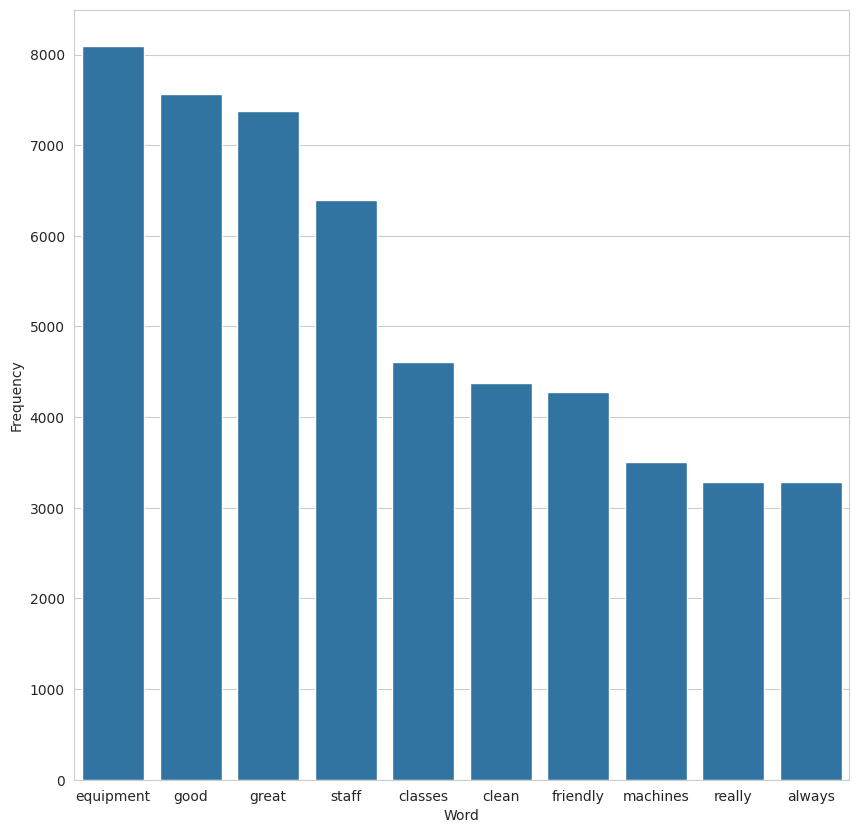

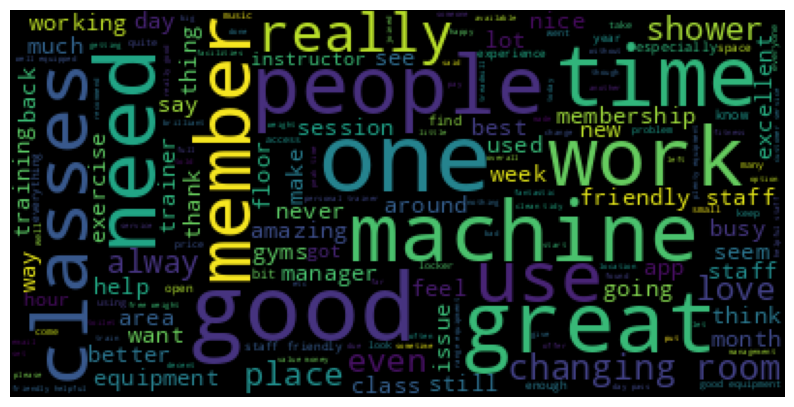

In [ ]:
word_cloud_display(combined_df)

The initial work shows generally positive words such as "good" and "great" and also indicate that people could be happy with the staff, classes and cleanliness of the gyms. It is worth noting that the sentiment of good and great could be altered by the addition of "not" before them, so this may not be the clearest picture.

When analysing reviews, while it is important to understand what you are doing right, the biggest opportunity for positive change is to focus on rectifying what you have done wrong. Therefore, for the remainder of the exercise we will focus on "negative" reviews. I am going to define these as reviews that have a score below 3/5.

In [ ]:
# Create new dataframes containing only negative reviews
google_negative_df = google_df[google_df['Score'] < 3]
trustpilot_negative_df = trustpilot_df[trustpilot_df['Score'] < 3]
combined_negative_df = combined_df[combined_df['Score'] < 3]

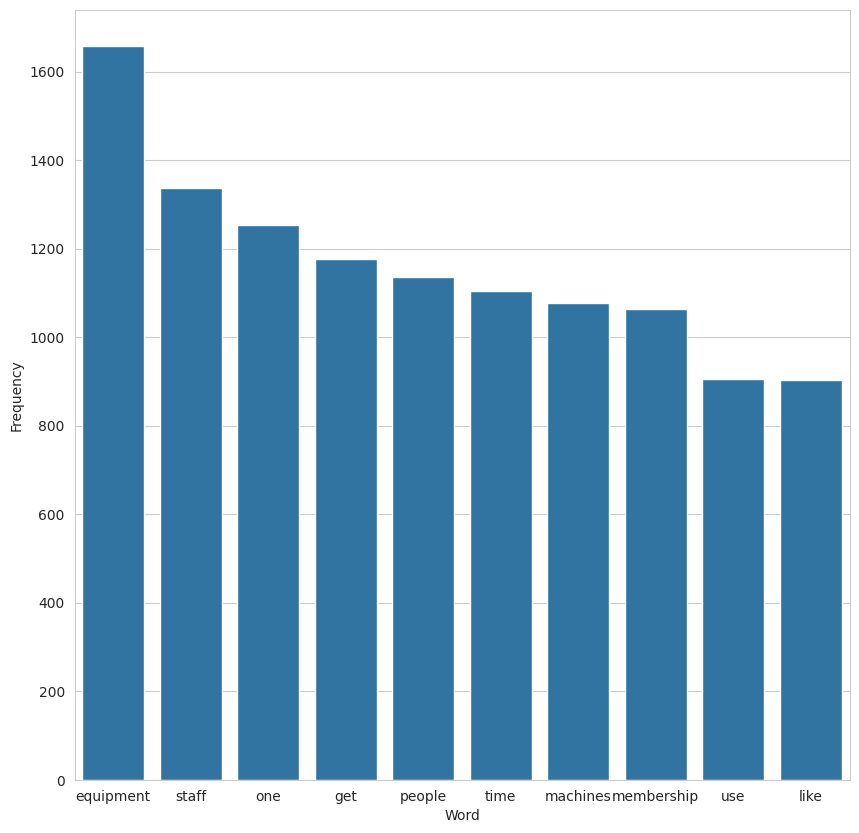

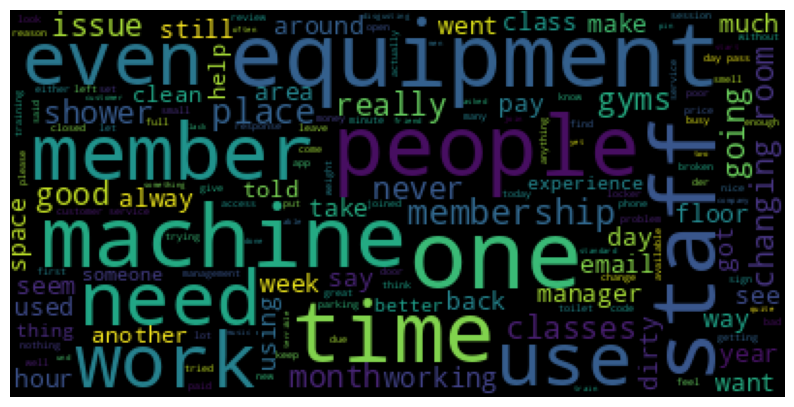

In [ ]:
word_cloud_display(combined_negative_df)

The analysis on the negative reviews indicate that people may be unhappy with the equipment, staff and membership.

This preliminary analysis is useful at a very high level to understand what the reviews may reference but it is very vague and doesn't give us much insight into the nature of the reviews or any corrective action that may be necessary.

## Performing further data investigation

Due to the large number of gym locations offered by Puregym, it will be extremely difficult to implement recommendations for each in this brief exercise. As such, it makes sense to focus on clubs where we have the most data. Also, the Google reviews list still contains some reviews that are not written in English and does not contain a review language feature to easily filter these out.

For simplicity, instead of transalting these we will only look at reviews in which the `Gym_Location` is common between the two data sources. As the Trustpilot set only contains reviews in English, it is likely that the common clubs will be based in the UK with reviews in English.

In [ ]:
# Check number of unique clubs for google dataset
google_unique_gyms = google_df["Gym_Location"].nunique()

# Check number of unique clubs for trustpilot dataset
trustpilot_unique_gyms = trustpilot_df['Gym_Location'].nunique()

# Find the common locations between both datasets
google_clubs = google_df["Gym_Location"].unique()
trustpilot_clubs = trustpilot_df['Gym_Location'].unique()

common_clubs = set(google_clubs).intersection(set(trustpilot_clubs))

print("Number of unique clubs in Google dataset:", google_unique_gyms)
print("Number of unique clubs in Trustpilot dataset:", trustpilot_unique_gyms)
print("Number of common clubs:", len(common_clubs))

Number of unique clubs in Google dataset: 512
Number of unique clubs in Trustpilot dataset: 376
Number of common clubs: 310


In [ ]:
# From the negative data sets, filter for gyms that are common between both data sets
common_negative_google_df = google_negative_df[google_negative_df["Gym_Location"].isin(common_clubs)]
common_negative_trustpilot_df = trustpilot_negative_df[trustpilot_negative_df['Gym_Location'].isin(common_clubs)]
common_negative_df = combined_negative_df[combined_negative_df['Gym_Location'].isin(common_clubs)]

The negative reviews will be grouped to see the location of the gyms with the highest frequency of negative reviews. Analysing the source of negative reviews in these gyms could provide the greatest potential for corrective action impacting the total review scores.

In [ ]:
# Group the Google reviews by location and count the number of negative reviews for each location
negative_google_df_by_location = common_negative_google_df[["Gym_Location"]]
negative_google_df_by_location = negative_google_df_by_location.dropna()
negative_google_df_by_location["Gym_Location"] = negative_google_df_by_location["Gym_Location"].astype(str)
negative_google_df_by_location = negative_google_df_by_location.groupby(["Gym_Location"])["Gym_Location"].count().reset_index(name='total_count_g')
negative_google_df_by_location_sorted = negative_google_df_by_location.sort_values(by=['total_count_g'], ascending=False)

In [ ]:
# Group the Trustpilot reviews by location and count the number of negative reviews for each location
negative_trustpilot_df_by_location = common_negative_trustpilot_df[["Gym_Location"]]
negative_trustpilot_df_by_location = negative_trustpilot_df_by_location.dropna()
negative_trustpilot_df_by_location["Gym_Location"] = negative_trustpilot_df_by_location["Gym_Location"].astype(str)
negative_trustpilot_df_by_location = negative_trustpilot_df_by_location.groupby(["Gym_Location"])["Gym_Location"].count().reset_index(name='total_count_tp')
negative_trustpilot_df_by_location_sorted = negative_trustpilot_df_by_location.sort_values(by=['total_count_tp'], ascending=False)

In [ ]:
# Merge the two datasets and list the top 20 locations with the highest number of combined negative reviews
merged_location_bad_reviews_count_df = pd.merge(negative_google_df_by_location_sorted, negative_trustpilot_df_by_location_sorted, how='left', on='Gym_Location')
merged_location_bad_reviews_count_df = merged_location_bad_reviews_count_df.dropna()
merged_location_bad_reviews_count_df['total_count'] = merged_location_bad_reviews_count_df['total_count_g'] + merged_location_bad_reviews_count_df['total_count_tp']
merged_location_bad_reviews_count_df_sorted = merged_location_bad_reviews_count_df.sort_values(by=['total_count'], ascending=False)

In [ ]:
print(merged_location_bad_reviews_count_df_sorted.shape)
merged_location_bad_reviews_count_df_sorted.head(20)

(290, 4)


,Gym_Location,total_count_g,total_count_tp,total_count
0,London Stratford,59,22.0,81.0
49,Leicester Walnut Street,11,50.0,61.0
2,London Enfield,25,23.0,48.0
3,London Swiss Cottage,24,15.0,39.0
5,Birmingham City Centre,21,14.0,35.0
6,New Barnet,20,14.0,34.0
10,London Seven Sisters,18,16.0,34.0
15,London Bermondsey,16,18.0,34.0
13,London Hayes,17,16.0,33.0
8,Bradford Thornbury,19,14.0,33.0


The data shows that the gyms with the highest frequency of negative reviews tendy to be in larg cities, with multiple London and Birmingham gyms in the top 20.

## Topic modelling

For the next stage of analysis we will conduct topic modelling usin BERTopic. BERTopic is a topic modeling technique that leverages transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.

In [ ]:
# Extract the review text for further analysis
bad_reviews_list = common_negative_df["Comment"].to_list()
len(bad_reviews_list)

3947

In [ ]:
# Define a function for cleaning the text in the reviews - change to lower case, remove stopwords etc
def clean_list(reviews_list):
    list_clean = []
    for review in reviews_list:
        if review is not None and review != "nan":
            review = review.lower()
            review = re.sub('[^A-Za-z]+', ' ', review)

            stop_words = set(stopwords.words('english'))
            additional_words = ['pure', 'gym', 'puregym', 'workout']
            stop_words.update(additional_words)
            word_tokens = word_tokenize(review)

            for w in word_tokens:
                if w in stop_words:
                    review = review.replace(" " + w + " ", " ")
            list_clean.append(review)

    return list_clean

In [ ]:
# Clean the bad reviews list
bad_reviews_list_clean = clean_list(bad_reviews_list)

In [ ]:
# Run the Bertopic model on the cleaned data
model = BERTopic(verbose=True)
model.fit(bad_reviews_list_clean)
topic, probabilities = model.transform(bad_reviews_list_clean)

Now that the model has formed the topics from the negative reviews we can have a look at what they relate to. First we will understand how many of the reviews relate to each topic.

In [ ]:
# Show the first 10 topics and their document frequencies
model.get_topic_freq().head(10)

,Topic,Count
1,-1,1797
2,0,193
6,1,153
18,2,132
16,3,115
4,4,104
7,5,81
39,6,79
20,7,73
15,8,71


In [ ]:
# Show the top words for the first topic
model.get_topic(-1)

[('equipment', 0.011312680241642227),
 ('staff', 0.010252194914896293),
 ('machines', 0.00979013021388366),
 ('one', 0.009622167162098355),
 ('people', 0.009183807324400915),
 ('like', 0.008690210883280052),
 ('time', 0.008481021565746299),
 ('changing', 0.008384303948456373),
 ('use', 0.008225942266256702),
 ('get', 0.008115732978727839)]

The topic with the most common negative reviews seems to relate to the equipment at the gym and perhaps suggests too many people are using them at one time.

In [ ]:
# Show the top words for the second topic
model.get_topic(0)

[('air', 0.0667373023624586),
 ('conditioning', 0.04183866376956198),
 ('aircon', 0.028408374661519995),
 ('hot', 0.028074816350372733),
 ('con', 0.026997763686138623),
 ('summer', 0.023257489685256854),
 ('ac', 0.02305043602343031),
 ('heat', 0.022923459657493563),
 ('temperature', 0.019707660006031788),
 ('working', 0.019024705002202737)]

The next topic is centered on the temperature of the gyms, indicating that perhaps the air conditioning isn't sufficient to keep a comfortable temperature in the summer.

In [ ]:
# Show the top words for the third topic
model.get_topic(1)

[('class', 0.06924526055332582),
 ('classes', 0.058747326285700216),
 ('instructors', 0.02317425722723942),
 ('booked', 0.022932577910847213),
 ('instructor', 0.021002559337876574),
 ('cancelled', 0.017940841486308055),
 ('pt', 0.01464770104370537),
 ('time', 0.013661206482418501),
 ('trainer', 0.012788701114083076),
 ('spin', 0.012786718387754104)]

The third topic suggests issues with booking classes at the gym, either problems with cancelled classes or the instructors.

We are also able to visualise these topics on a map that shows the 'intertopic distance' between each topic which simply means how similar the topics are to each other, with less similar topics being further away on the map.

In [ ]:
# Visualise the topics on the map
model.visualize_topics()

The chart provides a range of different topics, with some fairly clustered together and others floating more isolated. Ten topics identified from the analysis are regarding:

*   The equipment in the gym
*   The quality of the wifi in the gyms
*   Issues with joining and cancelling membership
*   Problems with parking
*   Issues with overcrowding
*   Problems with the air conditioning and temperature
*   Dirty bathrooms
*   Rude staff
*   Problems with the classes being booked
*   Cold showers



We can also display the first few topics, with a list of the words associate with each topic.

In [ ]:
# Display the topics on a barchart
model.visualize_barchart()

In general the bar charts summarise nicely different areas of concern:

*   The air conditioning and temperature inside the gym
*   Issues with the classes being booked
*   Problems with the weights and machinery
*   Potential lack of free parking
*   Having to wait for equipment
*   Poor hygiene in the bathrooms
*   Issues with day passes   
*   Opening times on holidays

## Emotion analysis

In addition to topic modelling, we can analyse the reviews for emotions, with a model being able to detect the top emotions presented in a body of text. It will then present a series of possible emotions with a confidence score for each.

In [ ]:
# Download the model for emotion analysis
classifier = pipeline("text-classification", model='bhadresh-savani/bert-base-uncased-emotion', return_all_scores=True)

To test the model we can use a sentence with clearly negative emotions such as possible anger.

In [ ]:
# Set a test prompt for the model
test_prompt = "I absolutely despise this gym"

In [ ]:
emotion_labels = classifier(test_prompt, )

In [ ]:
emotion_labels_sorted = sorted(emotion_labels[0], key=lambda x: x["score"], reverse=True)

In [ ]:
# Show the emotion labels and their scores
print(emotion_labels_sorted)

[{'label': 'anger', 'score': 0.9952940344810486}, {'label': 'sadness', 'score': 0.002515623578801751}, {'label': 'love', 'score': 0.0006875057006254792}, {'label': 'fear', 'score': 0.0006212494918145239}, {'label': 'joy', 'score': 0.0005875573260709643}, {'label': 'surprise', 'score': 0.0002939731639344245}]


The above shows that anger was indeed the most dominant emotion in the test text with a score of 99%.

We can now use the model to analyse the negative reviews that we have extracted earlier in the process.

In [ ]:
def get_top_emotion(review_list):
    """
    Takes a list of reviews and returns a list of the top emotion for each review
    """
    emotion_label_list = []

    for review in review_list:
        emotion_labels = classifier(review, truncation=True, padding=True, max_length=512)
        emotion_labels_sorted = sorted(emotion_labels[0], key=lambda x: x["score"], reverse=True)
        emotion_label_list.append(emotion_labels_sorted[0]["label"])

    return emotion_label_list

In [ ]:
# Extract bad reviews as a list
bad_reviews_list = common_negative_df["Comment"].to_list()

In [ ]:
# Extract the top emotion for each review in the data
top_neg_emotions = get_top_emotion(bad_reviews_list)

In [ ]:
# Add the top emotion to the dataframe as a new column
common_negative_df['Emotion'] = top_neg_emotions

Plotting the negative emotions will allow us to visualise the most common emotions in the negative reviews.

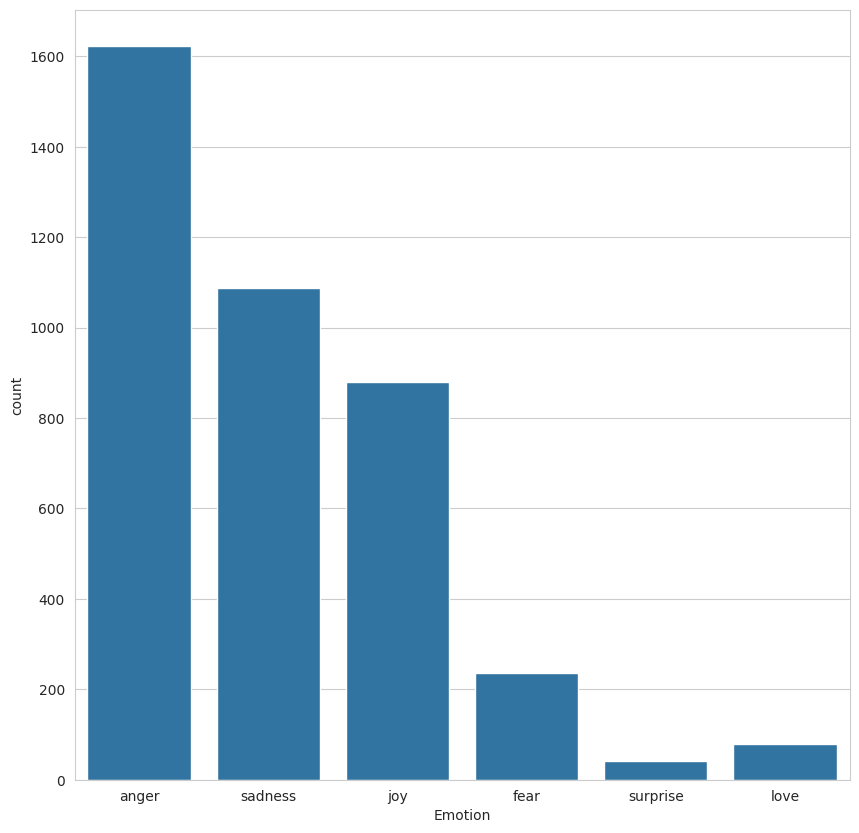

In [ ]:
# Plot a bar chart showing the top emotion distribution for all negative reviews
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Emotion", data=common_negative_df)
plt.show()

The analysis shows that anger is the predominant emotion detected in the negative reviews. The analysis also shows joy and love which we would not expect to see in negative reviews.

Reviews where the predominant emotion is anger may be the best place to start when trying to implement positive change, hence we can re-run the topic modelling on these reviews to look for additional insights.

In [ ]:
# Extract the reviews were anger is the dominant emotion
anger_reviews = common_negative_df[common_negative_df['Emotion'] == 'anger']

In [ ]:
# Convert the review content column to a list
anger_reviews_list = anger_reviews["Comment"].to_list()
len(anger_reviews_list)

1622

In [ ]:
# Clean the list
anger_reviews_list_clean = clean_list(anger_reviews_list)

In [ ]:
# Run the Bertopic model on the cleaned data
anger_model = BERTopic(verbose=True)
anger_model.fit(anger_reviews_list_clean)
topic, probabilities = anger_model.transform(anger_reviews_list_clean)

In [ ]:
# Show the top 10 topics and their document frequencies
anger_model.get_topic_freq().head(10)

,Topic,Count
4,-1,507
5,0,125
7,1,106
23,2,104
16,3,89
19,4,63
6,5,61
10,6,51
9,7,50
11,8,42


In [ ]:
# Visualise the topics on the map
anger_model.visualize_topics()

In [ ]:
# Visualise the topics on a barchart
anger_model.visualize_barchart()

The analysis on the angry reviews gives fairly clear groupings of reviews:

*   Problems with the weights and machinery
*   Cleanliness of the bathrooms
*   Membership and account troubles
*   Potential issues with day passes
*   Rude staff
*   Classes being cancelled
*   Behaviour of personal trainers
*   Problems with parking



## Using a Large Language Model from Hugging Face

While the insights generated so far can be useful, they are a bit vague and do not provide clear recommendations to improve the business. The next step will be to use an LLM to analyse the negative reviews and provide actionable insights to improve the customer experience.

The Phi-3.5 model will be used to analyse the negative reviews and provide contextual feedback from them that can be used to generate insights.

In [ ]:
# Download the Phi-3.5-mini-instruct model from Hugging Face
phi_model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3.5-mini-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct")

In [ ]:
# Create a pipeline for text generation using the Phi-3.5-mini-instruct model
pipe = pipeline(
    "text-generation",
    model=phi_model,
    tokenizer=tokenizer,
)

In [ ]:
# Set the generation arguments for the pipeline
generation_args = {
    "max_new_tokens": 500,
    "return_full_text": False,
    "temperature": 0.0,
    "do_sample": False,
}

Due to lack of computing resources, the model will only be run on a subset of the data - the first 100 reviews in the bad review list.

In [ ]:
# Run the pipeline on the first 100 reviews in the bad reviews list to extract the topics
topics_llm = []

print(len(bad_reviews_list_clean))

iter = 0

for review in bad_reviews_list_clean[0:100]:
  if len(str(review)) < 1000:
    messages_1 = [
      {"role": "system", "content": "You work as a data analyst for a large gym company in the UK and you want to find and summarise topics for improvments from customer reviews. You must return these in an array of strings only ['topic 1', 'topic 2', 'topic 3', ...], with no additional context. Do not provide any other text than the array of strings. Do not provide a written summary before or after the array of strings."},
      {"role": "user", "content": "In the following customer review interaction pick out 5 main topics and return them as an array of topics: The showers are disgusting"},
      {"role": "assistant", "content": '["Shower cleanliness", "Bad odour", "customer discomfort", "Poor hygiene", "Gym cleanliness"]'},
      {"role": "user", "content": f"In the following customer review interaction pick out 5 main topics and return them as an array of topics: {review}"},
    ]
    output = pipe(messages_1, **generation_args)

    topic_list_string = output[0]['generated_text'].strip()

    if topic_list_string.startswith("[") and topic_list_string.endswith("]"):
      topic_list = json.loads(topic_list_string)

      topics_llm.append(topic_list)

The model has now generated a list of lists containing the top 5 identified themes or topics from each review that was analysed, we can view these below.

In [ ]:
# Print the list
print(topics_llm)

[['Overcrowding', 'Littering and cleanliness', 'Student behavior', 'Management and leadership', 'Political and social issues'], ['Hygiene issues', 'Overcrowding', 'Airflow and ventilation', 'Peak hours congestion', 'Location convenience'], ['AC system efficiency', 'Window functionality', 'Staff behavior', 'Gender-based customer treatment', 'Client experience'], ['Access to washroom', 'Lack of available facilities', 'Need for better assistance', 'Issue with pin or access system', 'Customer service improvement'], ['Staff performance', 'Overcrowding issues', 'Equipment shortage', 'Temperature control', 'Operational hours and closure'], ['Equipment capacity', 'Underutilized space', "Goer's behavior", 'Facility shortcomings', 'Potential for improvement'], ['Air conditioning functionality', 'Cooling system failure', 'Temperature control issues', 'Comfort during workouts', 'Gym equipment maintenance'], ['Scanner malfunction', 'Customer support issues', 'Member etiquette', 'Foul odor in areas'

For further analysis will will convert this to a single list of individual topics/themes.

In [ ]:
# Convert the list of lists to a single list
topic_string_array = [item for row in topics_llm for item in row]

In [ ]:
# Show the top 20 items in the list
topic_string_array[:20]

['Overcrowding',
 'Littering and cleanliness',
 'Student behavior',
 'Management and leadership',
 'Political and social issues',
 'Hygiene issues',
 'Overcrowding',
 'Airflow and ventilation',
 'Peak hours congestion',
 'Location convenience',
 'AC system efficiency',
 'Window functionality',
 'Staff behavior',
 'Gender-based customer treatment',
 'Client experience',
 'Access to washroom',
 'Lack of available facilities',
 'Need for better assistance',
 'Issue with pin or access system',
 'Customer service improvement']

A quick look at the generated text shows that the LLM provides much more useful context for the negative reviews and echoes some of the same topics as before.

The LLM was able to produce more clearly defined topics from the reviews which may improve the performance of the topic modelling with BERTopic.

In [ ]:
# Clean the list
topic_string_array_clean = clean_list(topic_string_array)

In [ ]:
# Run the Bertopic model on the cleaned data
llm_model = BERTopic(verbose=True)
llm_model.fit(topic_string_array_clean)
topic, probabilities = llm_model.transform(topic_string_array_clean)

In [ ]:
# Show the top 10 topics and their document frequencies
llm_model.get_topic_freq().head(10)

,Topic,Count
8,0,66
1,1,48
3,-1,45
11,2,39
6,3,33
13,4,32
5,5,27
14,6,27
9,7,26
7,8,25


In [ ]:
# Visualise the topics on the map
llm_model.visualize_topics()

The map provides much more tightly grouped topics than the previous analysis with three main clusters generally regarding:

*   Overcrowding and congestion
*   Cleanliness and environment in the gyms
*   Staff behaviour and administrative issues



In [ ]:
# Visualise the topics on a barchart
llm_model.visualize_barchart()

The bar chart provides extremely useful groupings for the new insights.

By feeding the extracted topics back into the LLM we can also generate actionable recommendations to improve the customer experience in the gyms. We will do this by altering the system prompt to ask for improvements.

In [ ]:
# Set the prompt for the LLM to compress the topics into actionable insights
messages_2 = [
    {"role": "system", "content": "You work as a data analyst insights guru for a large gym company in the UK and you want to compress a given list into collated topics. You should return these in a numbered list as business insights that can be used to improve the business"},
    {"role": "user", "content": "In the following list containing the main extracted topics from customer reviews, group or compress the topics and return them with actionable insights in a numbered list: [Poor service experience','Faulty equipment','Overcrowding at peak times','Gym quality','Cleanliness of establishment','Potential health and safety concerns']"},
    {"role": "assistant", "content": "1. Service: Introduce training for staff to ensure that service is improved across the company. \n 2. Equipment quality: Review the equipment and replace or repair any faulty equipment. \n 3. Ensure that gyms are not overcrowded at peak times by optimising membership numbers \n..."},
    {"role": "user", "content": f"In the following list containing the main extracted topics from customer reviews, group or compress the topics and return them with actionable insights in a numbered list: {topic_string_array}"},
]

In [ ]:
# Clear the GPU cache and collect garbage to free up memory
import gc
torch.cuda.empty_cache()
gc.collect()

195

In [ ]:
# Run the pipeline on the prompt to generate the insights
output = pipe(messages_2, **generation_args)

insights = output[0]['generated_text']

In [ ]:
# Print the insights generated by the LLM
print(insights)

 1. **Service Improvement**:
   - Implement staff training programs to enhance customer service skills.
   - Establish a clear and efficient complaint resolution process.

2. **Equipment and Maintenance**:
   - Conduct regular equipment checks and maintenance to prevent faults.
   - Replace or upgrade outdated or frequently malfunctioning equipment.

3. **Crowd Management**:
   - Optimize gym membership numbers to prevent overcrowding during peak times.
   - Implement a reservation system for peak hours to manage crowd flow.

4. **Hygiene and Cleanliness**:
   - Increase the frequency of cleaning, especially in high-traffic areas like locker rooms and showers.
   - Ensure proper disposal of waste and availability of hand sanitizers.

5. **Staff Behavior and Training**:
   - Provide ongoing training for staff on customer service, safety, and equipment handling.
   - Implement a zero-tolerance policy for inappropriate behavior and enforce it consistently.

6. **Facility Upgrades**:
   - 

The insights generated by the LLM are generally all actionable and aimed at the key areas of concern that have been highlighted from all of the analysis above. These suggestions could be further improved if the model was to run on the entire data set, however due to computing power restraints this could not be done. It does however provide a good proof of concept that useful insights can be generate in this manner.